## Smart Surveillance System.

---------------------------
### Discovering UPAR Dataset.
### Source: https://github.com/speckean/upar_dataset/tree/main/UPAR

In [ ]:
# Load the EasyDict
import pandas as pd
import pickle
import numpy as np
from PIL import Image
from IPython.display import display
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split






with open("dataset_all.pkl", "rb") as f:
    upar_data = pickle.load(f)

# Check the top-level keys
print(type(upar_data))
print(upar_data.keys())


<class 'easydict.EasyDict'>
dict_keys(['description', 'reorder', 'root', 'image_name', 'label', 'attr_name', 'dataset_ids', 'partition', 'weight_train', 'weight_val', 'weight_trainval', 'weight_test'])


In [12]:
print("image_name:", len(upar_data["image_name"]))
print("partition:", len(upar_data["partition"]))
print("label:", len(upar_data["label"]))


image_name: 224737
partition: 8
label: 224737


In [13]:
print(type(upar_data["partition"]))
print(upar_data["partition"].keys())
for key in upar_data["partition"]:
    print(f"{key}: {len(upar_data['partition'][key])} samples")


<class 'easydict.EasyDict'>
dict_keys(['train', 'val', 'test', 'trainval', 'dataset_train', 'dataset_val', 'dataset_test', 'dataset_trainval'])
train: 9 samples
val: 9 samples
test: 9 samples
trainval: 9 samples
dataset_train: 0 samples
dataset_val: 0 samples
dataset_test: 0 samples
dataset_trainval: 0 samples


In [14]:
image_names = upar_data["image_name"]
label_matrix = np.array(upar_data["label"])
attr_names = upar_data["attr_name"]

# Convert label vectors to readable dicts
attribute_dicts = [
    {attr_names[i]: val for i, val in enumerate(attr_vector)}
    for attr_vector in label_matrix
]

# Build DataFrame
upar_df = pd.DataFrame({
    "image_name": image_names,
    "attributes": attribute_dicts
})

# Preview
upar_df.head()


,image_name,attributes
0,Market1501/bounding_box_train/0002_c1s1_000451...,"{'Age-Young': 0, 'Age-Adult': 1, 'Age-Old': 0,..."
1,Market1501/bounding_box_train/0002_c1s1_000551...,"{'Age-Young': 0, 'Age-Adult': 1, 'Age-Old': 0,..."
2,Market1501/bounding_box_train/0002_c1s1_000776...,"{'Age-Young': 0, 'Age-Adult': 1, 'Age-Old': 0,..."
3,Market1501/bounding_box_train/0002_c1s1_000801...,"{'Age-Young': 0, 'Age-Adult': 1, 'Age-Old': 0,..."
4,Market1501/bounding_box_train/0002_c1s1_069056...,"{'Age-Young': 0, 'Age-Adult': 1, 'Age-Old': 0,..."


In [15]:
# Show all unique attribute names in UPAR
for attr in attr_names:
    print(attr)


Age-Young
Age-Adult
Age-Old
Gender-Female
Hair-Length-Short
Hair-Length-Long
Hair-Length-Bald
UpperBody-Length-Short
UpperBody-Color-Black
UpperBody-Color-Blue
UpperBody-Color-Brown
UpperBody-Color-Green
UpperBody-Color-Grey
UpperBody-Color-Orange
UpperBody-Color-Pink
UpperBody-Color-Purple
UpperBody-Color-Red
UpperBody-Color-White
UpperBody-Color-Yellow
UpperBody-Color-Other
LowerBody-Length-Short
LowerBody-Color-Black
LowerBody-Color-Blue
LowerBody-Color-Brown
LowerBody-Color-Green
LowerBody-Color-Grey
LowerBody-Color-Orange
LowerBody-Color-Pink
LowerBody-Color-Purple
LowerBody-Color-Red
LowerBody-Color-White
LowerBody-Color-Yellow
LowerBody-Color-Other
LowerBody-Type-Trousers&Shorts
LowerBody-Type-Skirt&Dress
Accessory-Backpack
Accessory-Bag
Accessory-Glasses-Normal
Accessory-Glasses-Sun
Accessory-Hat


### Creating a dataset 

In [16]:

"""" Transforming dictionary of one-hot-encoded  labels to a multi-feature dataframe, 
    this will help in data manipulation and into prepping dataset for training
"""
attributes_df = upar_df['attributes'].apply(pd.Series)
df_expanded = pd.concat([upar_df['image_name'], attributes_df], axis=1)

# Define your mapping (edit if your real structure differs)
groups = {
    "Age": ["Age-Young", "Age-Adult", "Age-Old"],
    "Gender": ["Gender-Female"],
    "Hair-Length": ["Hair-Length-Short", "Hair-Length-Long", "Hair-Length-Bald"],
    "UpperBody-Length": ["UpperBody-Length-Short"],
    "UpperBody-Color": [
        "UpperBody-Color-Black", "UpperBody-Color-Blue", "UpperBody-Color-Brown", "UpperBody-Color-Green",
        "UpperBody-Color-Grey", "UpperBody-Color-Orange", "UpperBody-Color-Pink", "UpperBody-Color-Purple",
        "UpperBody-Color-Red", "UpperBody-Color-White", "UpperBody-Color-Yellow", "UpperBody-Color-Other"
    ],
    "LowerBody-Length": ["LowerBody-Length-Short"],
    "LowerBody-Color": [
        "LowerBody-Color-Black", "LowerBody-Color-Blue", "LowerBody-Color-Brown", "LowerBody-Color-Green",
        "LowerBody-Color-Grey", "LowerBody-Color-Orange", "LowerBody-Color-Pink", "LowerBody-Color-Purple",
        "LowerBody-Color-Red", "LowerBody-Color-White", "LowerBody-Color-Yellow", "LowerBody-Color-Other"
    ],
    "LowerBody-Type": ["LowerBody-Type-Trousers&Shorts", "LowerBody-Type-Skirt&Dress"],
    "Accessory": [
        "Accessory-Backpack", "Accessory-Bag", "Accessory-Glasses-Normal", "Accessory-Glasses-Sun", "Accessory-Hat"
    ]
}

def infer_category(row, columns, prefix=None):
    for col in columns:
        if col in row and row[col]:
            if prefix:
                return col.replace(prefix, "")
            else:
                return col.split("-", 1)[-1]
    if "Gender-Female" in columns:
        return "Male"
    return None

# Apply for each group
for group, cols in groups.items():
    if group == "Gender":
        df_expanded[group] = df_expanded.apply(
            lambda row: "Female" if row.get("Gender-Female", 0) else "Male", axis=1)
    elif group.endswith("Length"):
        # Only 'Short' is present in one-hot, so assume 'Long' otherwise
        base = group.replace("-Length", "")
        short_col = cols[0]
        df_expanded[group] = df_expanded.apply(
            lambda row: "Short" if row.get(short_col, 0) else "Long", axis=1)
    elif "Color" in group or "Hair-Length" in group or "Type" in group or "Accessory" in group:
        prefix = group + "-"
        df_expanded[group] = df_expanded.apply(
            lambda row: infer_category(row, cols, prefix=prefix), axis=1)
    else:  
        prefix = group + "-"
        df_expanded[group] = df_expanded.apply(
            lambda row: infer_category(row, cols, prefix=prefix), axis=1)

final_cols = ["image_name"] + list(groups.keys())
df_categorical = df_expanded[final_cols]


print(df_categorical.head())



                                          image_name    Age Gender  \
0  Market1501/bounding_box_train/0002_c1s1_000451...  Adult   Male   
1  Market1501/bounding_box_train/0002_c1s1_000551...  Adult   Male   
2  Market1501/bounding_box_train/0002_c1s1_000776...  Adult   Male   
3  Market1501/bounding_box_train/0002_c1s1_000801...  Adult   Male   
4  Market1501/bounding_box_train/0002_c1s1_069056...  Adult   Male   

  Hair-Length UpperBody-Length UpperBody-Color LowerBody-Length  \
0       Short            Short             Red            Short   
1       Short            Short             Red            Short   
2       Short            Short             Red            Short   
3       Short            Short             Red            Short   
4       Short            Short             Red            Short   

  LowerBody-Color   LowerBody-Type       Accessory  
0            Blue  Trousers&Shorts  Glasses-Normal  
1            Blue  Trousers&Shorts            None  
2            Blue

In [17]:
df_categorical.tail()

,image_name,Age,Gender,Hair-Length,UpperBody-Length,UpperBody-Color,LowerBody-Length,LowerBody-Color,LowerBody-Type,Accessory
224732,RAP2/RAP_dataset/CAM21-2014-04-24-201404241234...,Adult,Male,Short,Long,Other,Long,Blue,Trousers&Shorts,None
224733,RAP2/RAP_dataset/CAM14-2014-02-14-201402141441...,Adult,Male,Short,Long,Red,Long,Grey,Trousers&Shorts,None
224734,RAP2/RAP_dataset/CAM21-2014-04-24-201404241234...,Adult,Male,Short,Long,Black,Long,Black,Trousers&Shorts,None
224735,RAP2/RAP_dataset/CAM21-2014-04-24-201404241225...,Adult,Male,Short,Long,Black,Long,Black,None,None
224736,RAP2/RAP_dataset/CAM16-2014-03-27-201403271028...,Adult,Male,Short,Long,Black,Long,Blue,Trousers&Shorts,Bag


In [18]:
df_categorical.to_csv('image_df.csv')

### EDA

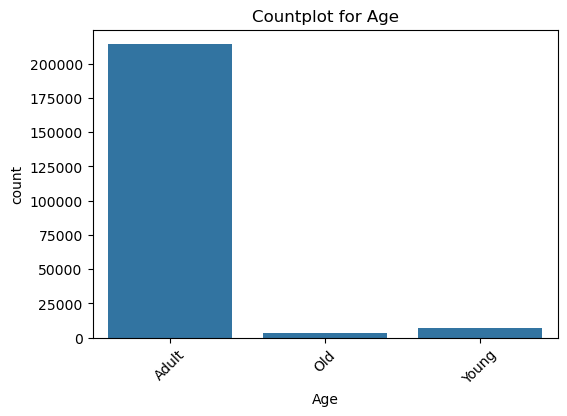

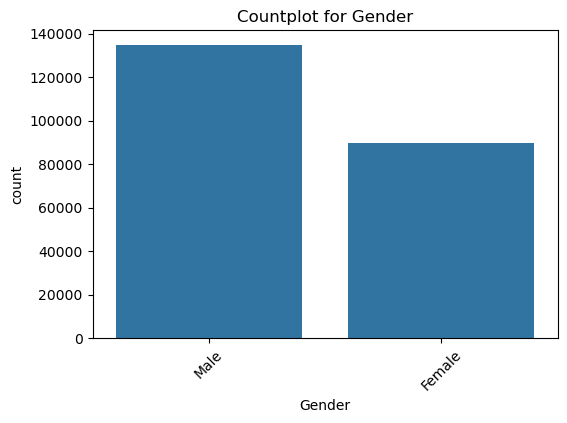

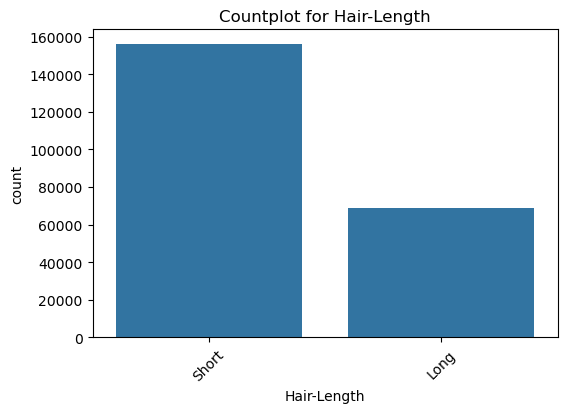

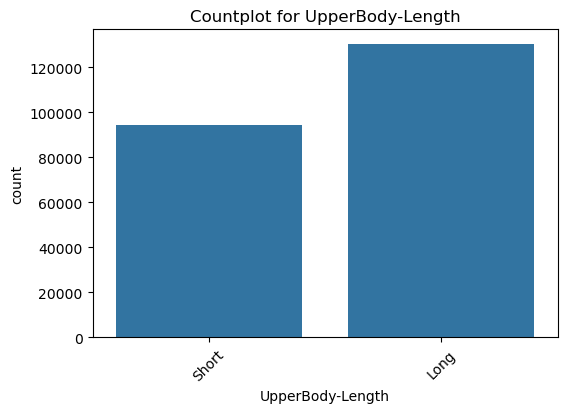

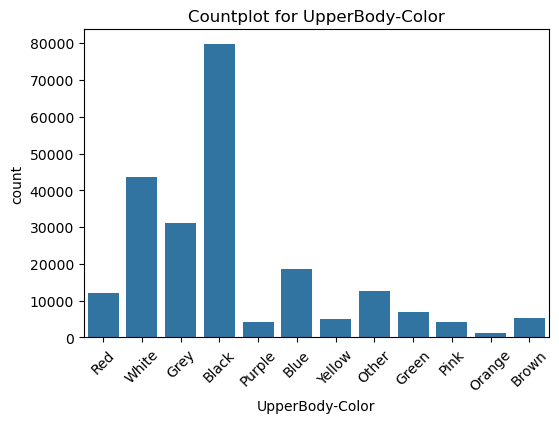

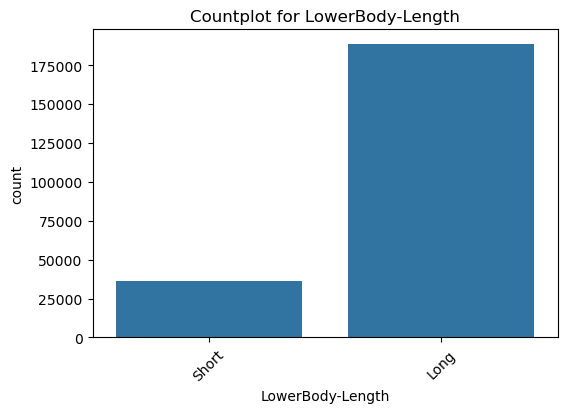

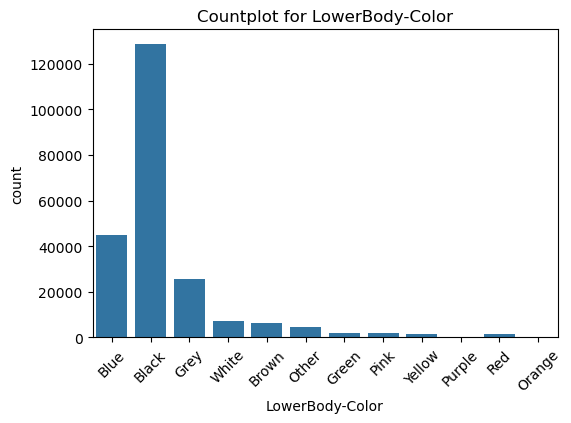

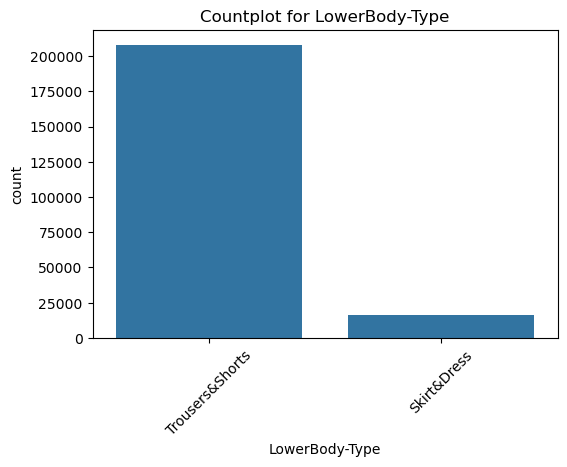

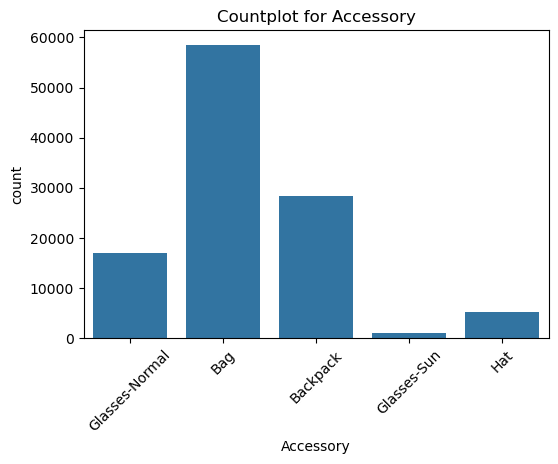

In [19]:
for col in df_categorical.columns[1:]:  
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df_categorical)
    plt.title(f'Countplot for {col}')
    plt.xticks(rotation = 45)
    plt.show()


In [ ]:
for col in df_categorical.columns[1:]:
    encoder = LabelEncoder()  
    df_categorical.loc[:, col] = encoder.fit_transform(df_categorical[col])


<Axes: >

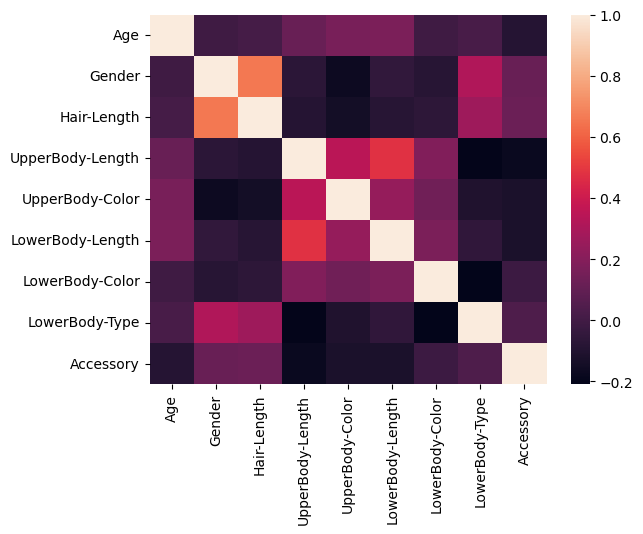

In [21]:
corr_mat = df_categorical.iloc[:,1:].corr()
sns.heatmap(corr_mat)

### Data Preprocessing, Normalizing

In [ ]:
def preprocessing(df):
    processed_imgs = []
    processed_idxs = []
    for i, img_path in enumerate(df['image_name'].values):
        if not os.path.isfile(img_path):
            continue
        try:
            img = Image.open(img_path)
            img_resized = img.resize((224, 224))
            arr = np.array(img_resized)
            arr = arr.astype('float32') / 255.0
            processed_imgs.append(arr)
            processed_idxs.append(i)  # Save the index of successful image
        except Exception as e:
            continue
    return np.stack(processed_imgs), processed_idxs

### Train Test Split

In [ ]:
train_df, test_df = train_test_split(df_categorical, test_size=0.2, random_state=42, shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

X_train, idx_train = preprocessing(train_df)
X_val, idx_val = preprocessing(val_df)
X_test, idx_test = preprocessing(test_df)

### Matching index with corresponding features

In [24]:
categorical_cols = df_categorical.columns[1:]

y_train = pd.get_dummies(train_df[categorical_cols], columns=categorical_cols).iloc[idx_train].values.astype(np.float32)
y_val = pd.get_dummies(val_df[categorical_cols], columns=categorical_cols).iloc[idx_val].values.astype(np.float32)
y_test = pd.get_dummies(test_df[categorical_cols], columns=categorical_cols).iloc[idx_test].values.astype(np.float32)


### Training set sanity check

In [25]:
# Find columns with nonzero sum in ANY split
nonzero_train = y_train.sum(axis=0) > 0
nonzero_val = y_val.sum(axis=0) > 0
nonzero_test = y_test.sum(axis=0) > 0
# Columns that are nonzero in at least one split
keep_cols = nonzero_train | nonzero_val | nonzero_test

y_train = y_train[:, keep_cols]
y_val   = y_val[:, keep_cols]
y_test  = y_test[:, keep_cols]


### Architecture

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.optimizers import Adam


input_shape = (224, 224, 3)  
num_classes = y_train.shape[1]           

model = Sequential([
    Conv2D(120, kernel_size= (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    
    Conv2D(60, kernel_size= (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(30, kernel_size=(3,3), activation= 'relu'),
    MaxPooling2D((2,2)),
    
    
    Flatten(),
    Dense(120, activation='relu'),
    Dropout(0.5),

    Dense(60, activation= 'relu'),
    Dropout(0.5),

    Dense(30, activation= 'relu'),
    Dropout(0.5),

    
    Dense(num_classes, activation='sigmoid')  
])

optimizer = Adam(learning_rate= .05)  

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model.summary()


/opt/anaconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 120)  │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 120)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 60)   │        64,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     2,433,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         1,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,528,438 (9.65 MB)

 Trainable params: 2,528,438 (9.65 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
history = model.fit(
    X_train,           
    y_train,          
    batch_size=200,
    epochs=10,
    validation_split=0.2,
)

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.2112 - loss: 0.6419 - val_accuracy: 0.9810 - val_loss: 0.4011
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.5976 - loss: 0.4346 - val_accuracy: 0.9810 - val_loss: 0.3488
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.6732 - loss: 0.3804 - val_accuracy: 0.9810 - val_loss: 0.3447
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.7658 - loss: 0.3650 - val_accuracy: 0.9810 - val_loss: 0.3350
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.8237 - loss: 0.3531 - val_accuracy: 0.9810 - val_loss: 0.3250
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.8279 - loss: 0.3426 - val_accuracy: 0.9810 - val_loss: 0.3164
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.8493 - loss: 0.3355 - val_accuracy: 0.9810 - val_loss: 0.3062
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.8291 - loss: 0.3288 - val_accuracy: 0.9347 - v

### Performance Plots

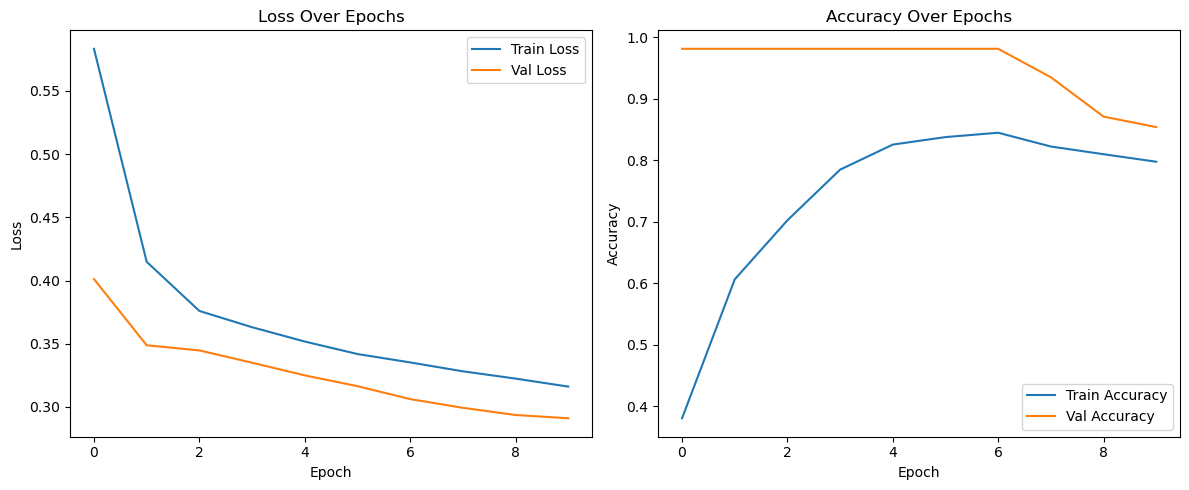

In [61]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Test

In [32]:
img_paths = 'test_photo.jpeg'
imgs = Image.open(img_paths)
img_resizedd = imgs.resize((224, 224))
arr = np.array(img_resizedd)
arrs = arr.astype('float32') / 255.0

In [54]:
img = Image.open('test_photo.jpeg')
img_resized = img.resize((224, 224))
img_array = np.array(img_resized).astype('float32') / 255.0

img_array = np.expand_dims(img_array, axis=0)  
y_pred = model.predict(img_array)  

pred_labels = (y_pred[0] > 0.5).astype(int)  
print(pred_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0]


###  UPAR Features

#### **Person Traits**
- `Age-Young`, `Age-Adult`, `Age-Old`
- `Gender-Female`
- `Hair-Length-Short`, `Hair-Length-Long`, `Hair-Length-Bald`

#### **Upper Body**
- Length: `UpperBody-Length-Short`
- Color: `Black`, `Blue`, `Brown`, `Green`, `Grey`, `Orange`, `Pink`, `Purple`, `Red`, `White`, `Yellow`, `Other`

#### **Lower Body**
- Length: `LowerBody-Length-Short`
- Color: same as upper body
- Type: `Trousers&Shorts`, `Skirt&Dress`

#### **Accessories**
- `Backpack`, `Bag`, `Glasses-Normal`, `Glasses-Sun`, `Hat`


---------------------------
### MAAD-Face: A Massively Annotated Attribute Dataset for Face Images
### Source: https://github.com/pterhoer/MAAD-Face

In [3]:
with open("MAAD_Face_1.0.pkl", "rb") as f:
    maad = pickle.load(f)

# Check the top-level keys
print(type(maad))
print(maad.keys())


<class 'pandas.core.frame.DataFrame'>
Index(['Filename', 'Identity', 'Male', 'Young', 'Middle_Aged', 'Senior',
       'Asian', 'White', 'Black', 'Rosy_Cheeks', 'Shiny_Skin', 'Bald',
       'Wavy_Hair', 'Receding_Hairline', 'Bangs', 'Sideburns', 'Black_Hair',
       'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'No_Beard', 'Mustache',
       '5_o_Clock_Shadow', 'Goatee', 'Oval_Face', 'Square_Face', 'Round_Face',
       'Double_Chin', 'High_Cheekbones', 'Chubby', 'Obstructed_Forehead',
       'Fully_Visible_Forehead', 'Brown_Eyes', 'Bags_Under_Eyes',
       'Bushy_Eyebrows', 'Arched_Eyebrows', 'Mouth_Closed', 'Smiling',
       'Big_Lips', 'Big_Nose', 'Pointy_Nose', 'Heavy_Makeup', 'Wearing_Hat',
       'Wearing_Earrings', 'Wearing_Necktie', 'Wearing_Lipstick', 'No_Eyewear',
       'Eyeglasses', 'Attractive'],
      dtype='object')


In [6]:
df = pd.read_csv('MAAD_Face.csv')
df.head()

/var/folders/s9/vpff5dcd39jfgbrc9w57xnrw0000gn/T/ipykernel_35140/798256715.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('MAAD_Face.csv')


,Filename,Identity,Male,Young,Middle_Aged,Senior,Asian,White,Black,Rosy_Cheeks,...,Big_Nose,Pointy_Nose,Heavy_Makeup,Wearing_Hat,Wearing_Earrings,Wearing_Necktie,Wearing_Lipstick,No_Eyewear,Eyeglasses,Attractive
0,n000002/0001_01.jpg,2,-1,1,-1,-1,-1,1,-1,0,...,-1,1,1,-1,1,-1,1,1,-1,1
1,n000002/0002_01.jpg,2,-1,1,-1,-1,-1,1,-1,0,...,-1,1,1,-1,1,-1,1,1,-1,1
2,n000002/0003_01.jpg,2,-1,1,-1,-1,-1,1,-1,0,...,-1,1,1,-1,1,-1,1,1,-1,1
3,n000002/0004_01.jpg,2,-1,1,-1,-1,-1,1,-1,0,...,-1,1,1,-1,1,-1,1,1,-1,1
4,n000002/0005_01.jpg,2,-1,1,-1,-1,-1,1,-1,0,...,-1,1,1,-1,1,-1,1,1,-1,1


In [2]:
import tarfile

tar_path = 'MAAD-Face-MAADFACE.tar'
extract_path = './'

with tarfile.open(tar_path, 'r') as tar:
    tar.extractall(path=extract_path)
    print(tar.getnames())


['MAAD-Face-MAADFACE', 'MAAD-Face-MAADFACE/README.md', 'MAAD-Face-MAADFACE/annotations', 'MAAD-Face-MAADFACE/annotations/info', 'MAAD-Face-MAADFACE/images', 'MAAD-Face-MAADFACE/images/Table_MAAD-Face_attribute_evaluation.png', 'MAAD-Face-MAADFACE/images/Table_databases.png', 'MAAD-Face-MAADFACE/images/info', 'MAAD-Face-MAADFACE/images/maad_2.tiff', 'MAAD-Face-MAADFACE/images/maad_4_2.tiff', 'MAAD-Face-MAADFACE/images/samples.png']


In [3]:
import tarfile
with tarfile.open(tar_path, 'r') as tar:
    tar.extract('MAAD-Face-MAADFACE/images/samples.png', path='./Datasets')


In [7]:
df['Identity'].unique()

array([2, 3, 4, ..., 9289, 9291, 9294], dtype=object)

<Axes: >

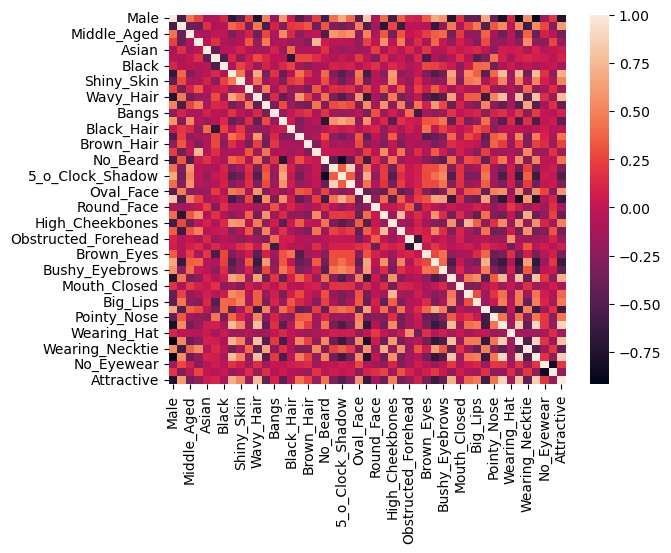

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_mat = df.iloc[:,1:].corr(numeric_only=True)
sns.heatmap(corr_mat)


---------------------------
### Discovering FairFace Dataset.
### Source: https://github.com/dchen236/FairFace

In [26]:
import pandas as pd

url = "https://raw.githubusercontent.com/dchen236/FairFace/master/test_outputs.csv"
fairface_df = pd.read_csv(url)

# Inspect structure
fairface_df.info()
fairface_df.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   face_name_align     5 non-null      object
 1   race                5 non-null      object
 2   race4               5 non-null      object
 3   gender              5 non-null      object
 4   age                 5 non-null      object
 5   race_scores_fair    5 non-null      object
 6   race_scores_fair_4  5 non-null      object
 7   gender_scores_fair  5 non-null      object
 8   age_scores_fair     5 non-null      object
dtypes: object(9)
memory usage: 488.0+ bytes


,face_name_align,race,race4,gender,age,race_scores_fair,race_scores_fair_4,gender_scores_fair,age_scores_fair
0,detected_faces/race_Asian_face0.jpg,East Asian,Asian,Female,30-39,[7.7522168e-04 1.1608704e-05 2.9779517e-03 9.3...,[3.9179469e-03 1.9815963e-05 9.9597895e-01 8.3...,[8.5034102e-05 9.9991494e-01],[5.3760527e-07 2.0359068e-05 1.2785579e-03 9.3...
1,detected_faces/race_Latino_face0.jpg,Latino_Hispanic,Asian,Female,20-29,[0.05775655 0.00232665 0.6921566 0.05506464 0...,[0.10278564 0.01113555 0.85227126 0.03380755],[4.2146090e-05 9.9995786e-01],[3.8011539e-08 8.2747183e-06 1.3017138e-02 7.2...
2,detected_faces/race_White_face0.jpg,White,White,Male,60-69,[9.6510637e-01 3.6202928e-05 1.4138068e-02 6.4...,[9.9643815e-01 1.9284267e-05 2.9810504e-03 5.6...,[0.85520303 0.144797 ],[1.35437411e-04 1.17149175e-04 1.96260633e-04 ...


###  FairFace Features

#### **Age Groups**
- `0-2`, `3-9`, `10-19`, `20-29`, `30-39`, `40-49`, `50-59`, `60-69`, `70+`

#### **Gender**
- `Male`, `Female`

#### **Race / Ethnicity**
- `White`, `Black`, `Latino_Hispanic`, `East Asian`, `Southeast Asian`, `Indian`, `Middle Eastern`  
- Also includes simplified 4-class version: `White`, `Black`, `Asian`, `Indian`

#### **Scores**
- `race_scores_fair`, `gender_scores_fair`, `age_scores_fair`: softmax output for confidence
